# Определение возраста человека по фото

В нашем распоряжении имеется датасет с набором фотографий лиц людей с указанием возраста.  
Задача состоит в том, чтобы обучить модель компьютерного зрения для определения приблизительного возраста человека.










# 1. Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from PIL import Image

In [2]:
data = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
data.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
# Размер выборки
len(data)

7591

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


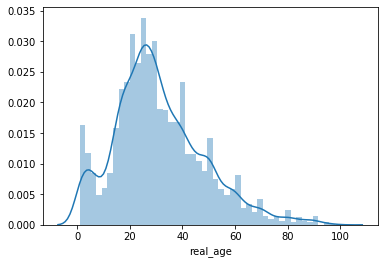

In [6]:
sns.distplot(data['real_age'])
plt.show()

Распределение немного скошено вправо. Присутствуют некие аномалии в возрастах от 0 до 10 лет.

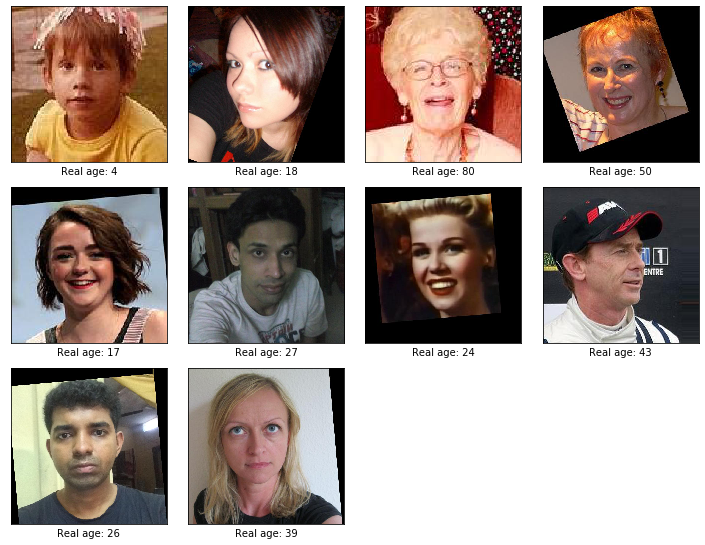

In [8]:
# выводим 10 изображений
fig = plt.figure(figsize=(10,10))
for i in range(10):
    filename = '00000' + str(i) + '.jpg'
    image = Image.open('/datasets/faces/final_files/' + filename)
    fig.add_subplot(4, 4, i+1)
    plt.imshow(image)
	# для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    x_label = 'Real age: ' + str(data.iloc[i, 1])
    plt.xlabel(x_label)
    plt.tight_layout()

Распределение по возрастам ~близко к нормальному~ немного смещено вправо. ~следовательно оно не будет сильно влиять на результат обучения.~  
Качество фотографий на среднем уровне. Этот фактор вполне может сыграть свою роль при обучении.

Встречаются несколько типов фотографий. Присутствуют селфи, фото, сделанные профессиональным фотографом, сканы бумажных изображений.  
Возможно изменение изображений по следующим параметрам:
 - вариация яркости (контрастности);
 - поворот на несколько десятков градусов в обе стороны;
 - отражение по горизонтали.  
 
 
Количесто изображений в данном наборе недостаточно для качестенного обучения модели. Более обширный набор позволил бы достигнуть лучших результатов.

# 2. Обучение модели

**Обучим нейронную сеть:**

```python

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
 
 
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
 
    return train_gen_flow
 
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
 
    return test_gen_flow
 
def create_model(input_shape):
    backbone = ResNet50(weights='imagenet',
                        input_shape=input_shape,
                        include_top=False)
 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
 
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
 
    return model
 
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
 
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
 
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
 
    return model

```

**Результат работы нейроной сети:**

```

Train for 356 steps, validate for 119 steps
Epoch 1/20
2020-11-06 18:38:56.385091: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-11-06 18:39:00.582306: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 117s - loss: 206.0952 - mae: 10.8249 - val_loss: 284.6698 - val_mae: 12.8405
Epoch 2/20
356/356 - 40s - loss: 129.6128 - mae: 8.7028 - val_loss: 265.0367 - val_mae: 12.3387
Epoch 3/20
356/356 - 40s - loss: 109.7948 - mae: 7.9966 - val_loss: 122.0878 - val_mae: 8.6134
Epoch 4/20
356/356 - 41s - loss: 88.6558 - mae: 7.2007 - val_loss: 208.9940 - val_mae: 10.8587
Epoch 5/20
356/356 - 40s - loss: 75.4464 - mae: 6.6583 - val_loss: 109.5504 - val_mae: 7.9543
Epoch 6/20
356/356 - 41s - loss: 68.0105 - mae: 6.3222 - val_loss: 122.0506 - val_mae: 8.7813
Epoch 7/20
356/356 - 41s - loss: 55.3608 - mae: 5.7322 - val_loss: 149.9927 - val_mae: 9.9546
Epoch 8/20
356/356 - 40s - loss: 48.8503 - mae: 5.4029 - val_loss: 97.5201 - val_mae: 7.4963
Epoch 9/20
356/356 - 41s - loss: 41.2095 - mae: 4.9316 - val_loss: 86.4579 - val_mae: 7.0057
Epoch 10/20
356/356 - 41s - loss: 37.4832 - mae: 4.6947 - val_loss: 103.9629 - val_mae: 7.6901
Epoch 11/20
356/356 - 40s - loss: 31.5464 - mae: 4.3789 - val_loss: 99.4554 - val_mae: 7.5482
Epoch 12/20
356/356 - 41s - loss: 27.5206 - mae: 4.0341 - val_loss: 84.0631 - val_mae: 6.8294
Epoch 13/20
356/356 - 40s - loss: 24.6697 - mae: 3.8351 - val_loss: 83.2499 - val_mae: 6.9806
Epoch 14/20
356/356 - 40s - loss: 22.0868 - mae: 3.6060 - val_loss: 119.3035 - val_mae: 8.5439
Epoch 15/20
356/356 - 41s - loss: 22.7791 - mae: 3.6800 - val_loss: 80.1826 - val_mae: 6.7198
Epoch 16/20
356/356 - 40s - loss: 19.9485 - mae: 3.4578 - val_loss: 87.9051 - val_mae: 6.9729
Epoch 17/20
356/356 - 40s - loss: 18.9640 - mae: 3.3441 - val_loss: 83.3211 - val_mae: 6.8260
Epoch 18/20
356/356 - 40s - loss: 18.6675 - mae: 3.3300 - val_loss: 85.5802 - val_mae: 6.8390
Epoch 19/20
356/356 - 40s - loss: 17.4592 - mae: 3.2131 - val_loss: 84.4455 - val_mae: 6.7915
Epoch 20/20
356/356 - 40s - loss: 17.8771 - mae: 3.2529 - val_loss: 93.1582 - val_mae: 7.2637
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 93.1582 - mae: 7.2637
Test MAE: 7.2637

```

# 3. Анализ обученной модели

По результатам обучения было получено среднее абсолютное отклонение, равное 7 годам. На распределении видно, что основная часть покупателей - люди в возрасте около 30 лет. Т.е. разброс в возрасте от 23 до 37 лет не сыграет существенной роли в товарах, которые можно предлагать таким клиентам.  
А если наоборот, клиенту 60 лет, то тут уже стоило бы обращать внимание на возраст и рекламировать ту продукцию, которая подошла бы наилучшим образом.  
Также система не подойдет для возможности определения возраста при продаже алкоголя и табачных изделий.  
Таким образом, на данный момент запускать в работу такую систему рисковано.